Now let's test how would the things work if we consider a 2-D gaussian and use a NF architecture based on slope-constrained neural splines!

In [1]:
import platform
print(platform.architecture())

('64bit', 'WindowsPE')


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from activations.linearspline_slope_constraint import LinearSplineSlopeConstrained

import os
import json
from tqdm import tqdm

import torch.optim as optim
from torch.nn.utils import clip_grad_norm_

In [3]:
def plot_loss_curves(train_loss, val_loss,title, log_scale=False):
    ''' plots train and val loss'''
    plt.figure()
    plt.plot(train_loss,"-o" ,label="train")
    plt.plot(val_loss, "-o",label = "val")
    if log_scale:
        plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.title(title)
    plt.legend()
    plt.show()

In [4]:
def plot_2d_scatter_with_marginals(data):
    """
    Plot a 2D scatter plot with marginal histograms for a 2D dataset.

    Args:
    - data: 2D numpy array of shape (n_samples, 2)

    Returns:
    None (displays the plot)
    """
    # Create a joint plot with scatter and marginal histograms
    g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind="scatter", marginal_kws=dict(bins=30, fill=True))

    # Add grid to the scatter plot axes
    g.ax_joint.grid(True)

    # Optionally, add grid to the marginal histograms
    g.ax_marg_x.grid(True)
    g.ax_marg_y.grid(True)

    # Display the plot
    plt.show()

In [5]:
def plot_coefficients_evolution(num_coeffs,coeffs, slope_constr_coeffs, log_scale=0):
    ''' 
    coeffs= List[list]: 
        e.g. [ [c1(t0),c2(t0),c3(t0)], [c1(t1),c2(t1),c3(t1)] ,..., 
        [c1(tn),c2(tn),c3(tn)]]
    slope_constr_coeffs = List[list]
    
    '''
    plt.figure(figsize=(10, 6))

    for i in range(0,num_coeffs):
        plt.plot(coeffs[:,i],"-o",label=f"coeff[{i}]")
        plt.plot(slope_constr_coeffs[:,i],":o",label=f"slope constr coeff[{i}]")
    
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
    
    if log_scale:
        plt.yscale("log")
    plt.xlabel("training epochs")
    plt.ylabel("coefficient values")
    plt.grid(1)
    plt.title("Evolution of coefficients with training of a spline")
    plt.tight_layout()


In [6]:
# Function to generate data from a 2D Gaussian distribution
def generate_2d_gaussian_data(mean, cov_matrix, total_samples, train_ratio=0.7, val_ratio=0.15):
    """
    Generate training, validation, and test datasets from a 2D Gaussian distribution.

    Parameters:
    - mean: Mean vector of the 2D Gaussian distribution (list or array of length 2)
    - cov_matrix: Covariance matrix of the 2D Gaussian distribution (2x2 matrix)
    - total_samples: Total number of samples to generate
    - train_ratio: Proportion of data to use for training (default is 70%)
    - val_ratio: Proportion of data to use for validation (default is 15%)

    Returns:
    - train_data: Training set
    - val_data: Validation set
    - test_data: Test set
    """
    # Generate 2D Gaussian data
    data = np.random.multivariate_normal(mean, cov_matrix, total_samples)

    # Shuffle data
    np.random.shuffle(data)

    # Split data based on ratios
    train_end = int(total_samples * train_ratio)
    val_end = train_end + int(total_samples * val_ratio)

    train_data = data[:train_end]
    val_data = data[train_end:val_end]
    test_data = data[val_end:]

    return train_data, val_data, test_data

# Function to convert datasets into DataLoaders
def create_dataloaders(train_data, val_data, test_data, batch_size=32):
    """
    Convert numpy arrays into PyTorch DataLoaders.

    Parameters:
    - train_data: Training dataset (numpy array)
    - val_data: Validation dataset (numpy array)
    - test_data: Test dataset (numpy array)
    - batch_size: Batch size for the DataLoaders

    Returns:
    - train_loader: DataLoader for training data
    - val_loader: DataLoader for validation data
    - test_loader: DataLoader for test data
    """
    # Convert numpy arrays to PyTorch tensors
    train_tensor = torch.tensor(train_data, dtype=torch.float32)
    val_tensor = torch.tensor(val_data, dtype=torch.float32)
    test_tensor = torch.tensor(test_data, dtype=torch.float32)

    # Create TensorDatasets
    train_dataset = TensorDataset(train_tensor)
    val_dataset = TensorDataset(val_tensor)
    test_dataset = TensorDataset(test_tensor)

    # Create DataLoaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader, test_loader


mean = [2,0]  # Mean of the Gaussian (2D vector)
cov_matrix = [[2, 0], [0, 1]]  # Covariance matrix (2x2)
total_samples = 10000

# Generate the data
train_data, val_data, test_data = generate_2d_gaussian_data(mean, cov_matrix, total_samples)

# Convert to DataLoaders
batch_size = 8
train_loader, val_loader, test_loader = create_dataloaders(train_data, val_data, test_data, batch_size)

# Print dataset sizes
print(f"Training set size: {len(train_data)}")
print(f"Validation set size: {len(val_data)}")
print(f"Test set size: {len(test_data)}")

# generate the data and see how it works

Training set size: 7000
Validation set size: 1500
Test set size: 1500


In [7]:
def get_weight_determinants(model):
    """
    Calculate the determinants of the weight matrices of each linear layer in the model.

    Args:
    - model (nn.Module): The model containing the layers.

    Returns:
    - determinants (torch.tensor): A list of determinants of the weight matrices for each linear layer.
    """
    determinants = []

    # Iterate over all layers in the model
    for layer in model.modules():
        if isinstance(layer, nn.Linear):  # Check if it's a Linear layer
            # Calculate the determinant of the weight matrix if it's square
            if layer.weight.shape[0] == layer.weight.shape[1]:
                det = torch.linalg.det(layer.weight)
                determinants.append(det.item())  # Convert tensor to scalar and add to list
            else:
                print(f"Layer with weight matrix of shape {layer.weight.shape} is not square. Skipping determinant calculation.")
                determinants.append(None)
    return torch.tensor(determinants)

def prod_model_activations_jacobians(model):
    """
    Process the model's activations by:
    1. Performing column-wise multiplication for each activation layer.
    2. Pointwise multiplying the reduced vectors to obtain a final vector.

    Args:
        model: The model containing activations with grad_x_temp.

    Returns:
        A tensor representing the final pointwise multiplied vector.
    """
    reduced_activations = []
    
    # Iterate over all activations
    for i in range(len(model.activations)):
        # Get the grad_x_temp tensor for the current activation layer
        grad_x_temp = model.activations[i].grad_x_temp
        # print("grad_x_temp is:"); print(grad_x_temp)
        # Column-wise multiplication (reduce along rows)
        reduced = torch.prod(grad_x_temp, dim=0, keepdim=True)
        # print("reduced is:"); print(reduced)
        reduced_activations.append(reduced)
    
    # Perform pointwise multiplication across all reduced activations
    result_vector = reduced_activations[0]
    for reduced in reduced_activations[1:]:
        result_vector = result_vector * reduced  # Pointwise multiplication
    
    return result_vector


In [8]:
# DEFINING OUR LOSS
def nll_loss(z, det_jacob_act, linear_layers_det):
    '''
    z :  tensor z in latent space
    det_jacob_act:tensor of the form  (let there be three layers a,b,c and "N" xs)
        (a1a2..adb1b2..bdc1c2...cd|x1, .... , a1a2..adb1b2..bdc1c2...cd|xN)
    linear_layers_det:tensor of the form (for all "c" linear layers)
        (det(W_(1)),det(W_(2)), ... , det(W_(c)))
    '''

    loss_1 = 0.5 * torch.sum(z**2)
    # print("loss 1 is:"); print(loss_1)
    # summed over all 
    loss_2a = torch.sum(torch.log(torch.abs(det_jacob_act) + 1e-10))
    loss_2b =  torch.sum(torch.log(torch.abs(linear_layers_det)+ 1e-10))
    # print("loss_2a is:"); print(loss_2a)
    # print("loss_2b is:"); print(loss_2b)
    dataset_length = z.size(0)
    loss = ((loss_1-loss_2a)/ dataset_length) - loss_2b
    return loss

def TV2(model, device_info):
    """
    Computes the sum of the TV(2) (second-order total-variation)
    semi-norm of all linearspline activations in the network.
    Returns:
        tv2 (0d Tensor):
            tv2 = sum(TV(2))
    """
    tv2 = torch.Tensor([0.]).to(device_info)
    for module in model.modules():
        if isinstance(module, LinearSplineSlopeConstrained):
            module_tv2 = module.totalVariation(mode='additive')
            tv2 = tv2 + module_tv2.norm(p=1)
    # print("tv2 is:"); print(tv2)
    return tv2[0] 

In [9]:
class SplineNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim,
                spline_activation_class, spline_kwargs):
        """
        Neural Network model with learnable spline activation 
        functions per layer.
        
        Args:
        - input_dim (int): Size of the input features.
        - hidden_dim (int): Size of the hidden layers.
        - output_dim (int): Size of the output layer.
        - depth (int): Number of hidden layers.
        - spline_activation_class (type): Class of the learnable   
                                spline activation function.
        - spline_kwargs (dict): Keyword arguments to initialize 
                                each spline activation.
        """
        super(SplineNN, self).__init__()
        
        self.layers = nn.ModuleList()
        self.activations = nn.ModuleList()

        # Input layer
        if len(hidden_dim) !=0:
            self.layers.append(nn.Linear(input_dim, hidden_dim[0]))
        else:
            self.layers.append(nn.Linear(input_dim, output_dim))
        self.activations.append(spline_activation_class(**spline_kwargs))

        # Hidden layers with their own spline activations
        for i in range(len(hidden_dim)-1):
            self.layers.append(nn.Linear(hidden_dim[i], hidden_dim[i+1]))
            self.activations.append(spline_activation_class(**spline_kwargs))
        
        # output layer will have activation!
        if len(hidden_dim)!=0:
            self.layers.append(nn.Linear(hidden_dim[-1], output_dim))
            self.activations.append(spline_activation_class(**spline_kwargs))

    def forward(self, x):
        grad_x_temp_list=[]
        for layer, activation in zip(self.layers[:], self.activations):  # All layers except the last
            x1=layer(x)
            x= activation(x1)
            grad_x_temp_list.append(activation.grad_x_temp)
        return x,grad_x_temp_list

In [10]:
spline_params = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
    "init": "maxmin",
    "smin": 0.001,
    "smax": 1 / 0.001,
    "slope_constrained": True,
}
check_model=SplineNN(input_dim=2, hidden_dim=[2], output_dim=2,
                    spline_activation_class=LinearSplineSlopeConstrained,
                    spline_kwargs=spline_params)

initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000],
        [-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([ 12.6000,   8.0000,   5.4000,   9.0000,  13.0000, -18.9000, -12.0000,
          8.1000,  13.5000,  19.5000], requires_grad=True)
initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000],
        [-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([ 12.6000,   8.0000,   5.4000,   9.0000,  13.0000, -18.9000, -12.0000,
          8.1000,  13.5000,  19.5000], requires_grad=True)


d:\Desktop\lipschitz_network_third_sem\Lipschitz_DSNN\activations\linearspline_slope_constraint.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


I think I do not need to return grad_x_temp list in the forward function anymore

In [11]:
test_tensor = torch.tensor([[1.,2.],[1.3,2.3],[2.4,3.5]])
a,b= check_model(test_tensor)
print("a and b is:"); a,b

a and b is:


(tensor([[ 9.9763, 18.1794],
         [ 9.9756, 19.0583],
         [ 9.9728, 22.4282]], grad_fn=<ViewBackward0>),
 [tensor([[9.9993e-04, 9.9993e-04, 9.9993e-04],
          [3.0000e+00, 3.0000e+00, 3.0000e+00]],
         grad_fn=<LinearSpline_FuncBackward>),
  tensor([[1.0001e-03, 1.0001e-03, 1.0001e-03],
          [3.0000e+00, 3.0000e+00, 3.0000e+00]],
         grad_fn=<LinearSpline_FuncBackward>)])

In [12]:
# let's test the other functions:
#1. get_weight_determinants function
wt_det = get_weight_determinants(check_model)
# print("wt_det is:",wt_det); print(f"type(wt_det:){type(wt_det)}"): type is tensor now
#2. prod_model_activations_jacobians
prod_jacob_act = prod_model_activations_jacobians(check_model)

In [13]:
## next we check the modified nll_loss function
nll_loss(z=a,det_jacob_act=prod_jacob_act,linear_layers_det=wt_det)

tensor(262.4668, grad_fn=<SubBackward0>)

Trainer function

In [14]:
def train_and_evaluate(
    model, train_loader, val_loader, 
    lambda_tv2=1e-4, num_epochs=10, 
    lr=0.001, print_after=1, tv2_regulation=False, 
    scheduler_type="StepLR", step_size=5, gamma=0.1
    , track_coefficients = False
    ,max_grad_norm=None
):
    """
    Train the RealNVP model and evaluate on a validation dataset.

    Args:
    - model: The NF model to be trained.
    - train_loader (DataLoader): DataLoader for the training dataset.
    - val_loader (DataLoader): DataLoader for the validation dataset.
    - num_epochs (int): Number of training epochs.
    - lr (float): Learning rate for the optimizer.
    - print_after (int): Number of epochs after which to print the training and validation loss.
    - scheduler_type (str): Type of scheduler to use ("StepLR", "ExponentialLR","ReduceLROnPlateau", etc.).
    - step_size (int): Step size for the StepLR scheduler (if applicable).
    - gamma (float): Multiplicative factor for learning rate decay.

    Returns:
    - train_losses (list): List of training losses for each epoch.
    - val_losses (list): List of validation losses for each epoch.
    """

    # Define the optimizer
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Define the scheduler
    if scheduler_type == "StepLR":
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    elif scheduler_type == "ExponentialLR":
        scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=gamma)
    elif scheduler_type == "ReduceLROnPlateau":
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=gamma, patience=2)
    else:
        raise ValueError("Unsupported scheduler type. Choose from 'StepLR', 'ExponentialLR', or 'ReduceLROnPlateau'.")

    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    model_parameters = []  # List to store model parameters after each epoch
    if track_coefficients:
        coeffs_evol=[]
        slope_const_coeffs_evol=[]

    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        total_train_loss = 0.0

        if track_coefficients:
            # do I really need to change them to numpy?
            coeffs=model.coefficients_vect.detach().numpy()
            slope_const_coeffs = model.slope_constrained_coefficients_vect.detach().numpy()
            coeffs_evol.append(list(coeffs))
            slope_const_coeffs_evol.append(list(slope_const_coeffs))

        # Training phase
        model.train()  # Set the model to training mode
        for data in train_loader:
            inputs = data[0]  # data is a list containing the tensor [tensor()]

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass (encoding)
            encoded, _ = model(inputs)

            # get tensors of determinants 
            # needed to calculate loss fn
            wt_det = get_weight_determinants(model)
            prod_jacob_act = prod_model_activations_jacobians(model)

            # Loss calculation
            ## Normal loss term
            train_loss = nll_loss(z=encoded, 
                                det_jacob_act=prod_jacob_act,
                                linear_layers_det=wt_det)

            ### TV2 regularisation term
            if tv2_regulation:
                tv2_regul = TV2(model, model.coefficients_vect.device)

            ## Total loss
            if tv2_regulation:
                total_loss = train_loss + lambda_tv2 * tv2_regul
            else:
                total_loss = train_loss

            # Backward pass (gradient computation)
            total_loss.backward()

            # Gradient clipping
            if max_grad_norm is not None:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)


            # Update weights
            optimizer.step()
            total_train_loss += total_loss.item()
        
        # save the model parameters after each epoch
        # Save model parameters after the epoch
        epoch_parameters = [p.detach().cpu().numpy() for p in model.parameters()]
        model_parameters.append(epoch_parameters)

        # Step the scheduler
        if scheduler_type != "ReduceLROnPlateau":
            scheduler.step()
        else:
            scheduler.step(total_train_loss / len(train_loader))
        
        # Average training loss for the epoch
        average_train_loss = total_train_loss / len(train_loader)

        # Validation phase
        if val_loader is not None:
            model.eval()  # Set the model to evaluation mode
            total_val_loss = 0.0
            with torch.no_grad():
                for val_data in val_loader:
                    val_inputs = val_data[0]

                    # Forward pass (encoding) for validation
                    val_encoded,_ = model(val_inputs)

                    # get tensors of determinants 
                    # needed to calculate loss fn
                    val_wt_det = get_weight_determinants(model)
                    val_prod_jacob_act = prod_model_activations_jacobians(model)

                    # Loss calculation
                    ## Normal loss term
                    val_loss = nll_loss(
                        z=val_encoded, 
                        det_jacob_act=val_prod_jacob_act,
                        linear_layers_det=val_wt_det)

                    total_val_loss += val_loss.item()

            # Average validation loss for the epoch
            average_val_loss = total_val_loss / len(val_loader)

            # Print training and validation losses together
            if (epoch + 1) % print_after == 0:
                print(
                    f"Epoch {epoch + 1}/{num_epochs}, "
                    f"Training Loss: {average_train_loss}, "
                    f"Validation Loss: {average_val_loss}, "
                    f"LR: {scheduler.get_last_lr()[0]}"
                )

            # Append losses to the lists
            train_losses.append(average_train_loss)
            val_losses.append(average_val_loss)

        # Set the model back to training mode
        model.train()

    print("Training complete")

    if track_coefficients:
        return train_losses, val_losses, coeffs_evol, slope_const_coeffs_evol
    return train_losses, val_losses, model_parameters


Let's now train the model

In [37]:
# let's test the function and see if it works well
spline_params = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-8.3, -4, 2.7, 4.5, 9.0]),
    "init": "maxmin",
    "smin": 0.01, # notice that I have also fixed the value of smin 
    "smax": 1 / 0.01, # and smax quite a lot
    "slope_constrained": True,
} 

model_2d=SplineNN(input_dim=2, hidden_dim=[2], output_dim=2,
                    spline_activation_class=LinearSplineSlopeConstrained,
                    spline_kwargs=spline_params)

# train the model
train_losses, val_losses, model_param_epoch = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.001, 
    num_epochs=10, 
    print_after=1,
    scheduler_type="ReduceLROnPlateau",
    max_grad_norm=True,
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

Training Progress:   0%|          | 0/10 [00:00<?, ?it/s]

initial nodal_val_locs: tensor([[-8.3000, -4.0000,  2.7000,  4.5000,  9.0000],
        [-8.3000, -4.0000,  2.7000,  4.5000,  9.0000]])
initial fn values: Parameter containing:
tensor([ 16.6000,   8.0000,   5.4000,   9.0000,  18.0000, -24.9000, -12.0000,
          8.1000,  13.5000,  27.0000], requires_grad=True)
initial nodal_val_locs: tensor([[-8.3000, -4.0000,  2.7000,  4.5000,  9.0000],
        [-8.3000, -4.0000,  2.7000,  4.5000,  9.0000]])
initial fn values: Parameter containing:
tensor([ 16.6000,   8.0000,   5.4000,   9.0000,  18.0000, -24.9000, -12.0000,
          8.1000,  13.5000,  27.0000], requires_grad=True)


Training Progress:  10%|█         | 1/10 [00:15<02:20, 15.61s/it]

Epoch 1/10, Training Loss: 141.85047190638952, Validation Loss: 80.13160056256234, LR: 0.001


Training Progress:  20%|██        | 2/10 [00:31<02:06, 15.78s/it]

Epoch 2/10, Training Loss: 71.6483914969308, Validation Loss: 65.41484644057903, LR: 0.001


Training Progress:  30%|███       | 3/10 [00:47<01:49, 15.68s/it]

Epoch 3/10, Training Loss: 63.784547773088725, Validation Loss: 61.60139400401014, LR: 0.001


Training Progress:  40%|████      | 4/10 [01:02<01:34, 15.70s/it]

Epoch 4/10, Training Loss: 61.536615631103516, Validation Loss: 55.68040571821497, LR: 0.001


Training Progress:  50%|█████     | 5/10 [01:18<01:18, 15.72s/it]

Epoch 5/10, Training Loss: 64.352303024292, Validation Loss: 59.33062072510415, LR: 0.001


Training Progress:  60%|██████    | 6/10 [01:34<01:02, 15.65s/it]

Epoch 6/10, Training Loss: 79.53365435300555, Validation Loss: 69.62880463295795, LR: 0.001


Training Progress:  70%|███████   | 7/10 [01:49<00:46, 15.60s/it]

Epoch 7/10, Training Loss: 96.78070279107774, Validation Loss: 61.79913171555133, LR: 0.0001


Training Progress:  80%|████████  | 8/10 [02:07<00:32, 16.22s/it]

Epoch 8/10, Training Loss: 85.180769323349, Validation Loss: 58.53676635787842, LR: 0.0001


Training Progress:  90%|█████████ | 9/10 [02:28<00:17, 17.80s/it]

Epoch 9/10, Training Loss: 81.27260847922734, Validation Loss: 55.03336593064856, LR: 0.0001


Training Progress: 100%|██████████| 10/10 [02:45<00:00, 16.55s/it]

Epoch 10/10, Training Loss: 77.06293357842308, Validation Loss: 51.44719647600296, LR: 1e-05
Training complete


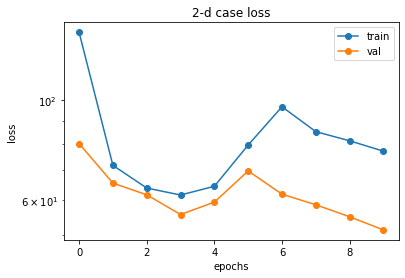

In [38]:
plot_loss_curves(train_loss=train_losses, val_loss=val_losses,
                title="2-d case loss", log_scale=True)

In [39]:
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

encoded_test

tensor([[ 2.5359,  0.8901],
        [ 5.8590,  0.4177],
        [ 5.0629,  0.2101],
        ...,
        [ 4.0310,  0.4801],
        [-0.5027,  0.1512],
        [ 7.0651, -0.3758]])

test_data original space:


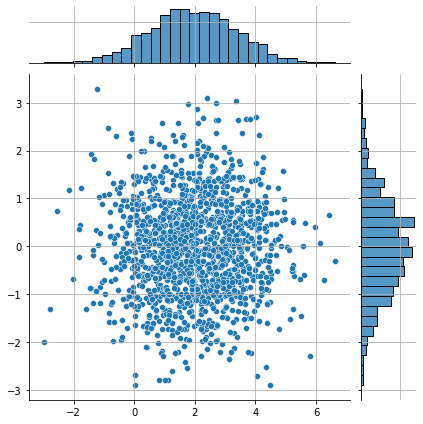

test data in encoded space


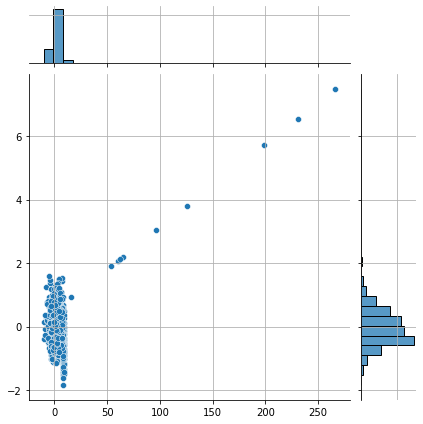

In [40]:
# now we can try to plot the code space 
print("test_data original space:") 
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

In [41]:
train_losses_3, val_losses_3, model_param_epoch_3 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.001, 
    num_epochs=6, 
    print_after=1,
    scheduler_type="ReduceLROnPlateau",
    max_grad_norm=True,
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

Training Progress:  17%|█▋        | 1/6 [00:15<01:16, 15.35s/it]

Epoch 1/6, Training Loss: 51.94614651121412, Validation Loss: 21.130101953098116, LR: 0.001


Training Progress:  33%|███▎      | 2/6 [00:30<01:01, 15.34s/it]

Epoch 2/6, Training Loss: 18.57906624685015, Validation Loss: 10.232687919380817, LR: 0.001


Training Progress:  50%|█████     | 3/6 [00:45<00:45, 15.22s/it]

Epoch 3/6, Training Loss: 8.369099524497987, Validation Loss: 5.222174329326508, LR: 0.001


Training Progress:  67%|██████▋   | 4/6 [01:01<00:30, 15.49s/it]

Epoch 4/6, Training Loss: 4.365547492912837, Validation Loss: 3.9834329200551863, LR: 0.001


Training Progress:  83%|████████▎ | 5/6 [01:20<00:16, 16.69s/it]

Epoch 5/6, Training Loss: 3.4803621023723057, Validation Loss: 3.1812022753218385, LR: 0.001


Training Progress: 100%|██████████| 6/6 [01:39<00:00, 16.54s/it]

Epoch 6/6, Training Loss: 2.866631556238447, Validation Loss: 2.6831009685993195, LR: 0.001
Training complete


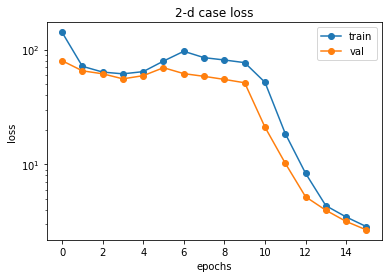

In [42]:
plot_loss_curves(train_loss=train_losses+train_losses_3, val_loss=val_losses+val_losses_3,
                title="2-d case loss", log_scale=True)

In [43]:
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

encoded_test

tensor([[ 0.6116,  0.2807],
        [ 1.9718,  0.0991],
        [ 1.6412,  0.0078],
        ...,
        [ 1.2207,  0.1160],
        [-0.6493, -0.0451],
        [ 2.4562, -0.2321]])

test_data original space:


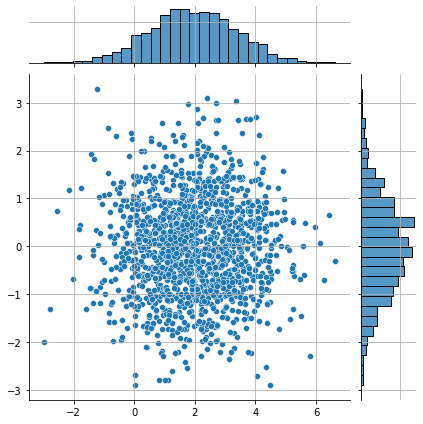

test data in encoded space


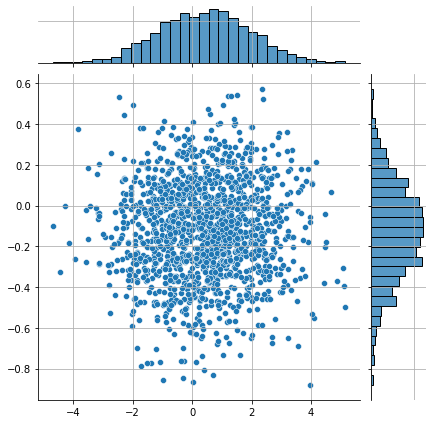

In [44]:
# now we can try to plot the code space 
print("test_data original space:") 
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

I did the early stopping and it did work! This is the first time I have seen early stopping in action! (atleast in some of the previous experiments I did).

In [45]:
# train the model for a few more epochs
train_losses_2, val_losses_2, model_param_epoch_2 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.001, 
    num_epochs=5, 
    print_after=1, 
    scheduler_type='ReduceLROnPlateau',
    track_coefficients=False # let's not track coeffs, i need to fix it
) 


Training Progress:  20%|██        | 1/5 [00:18<01:13, 18.49s/it]

Epoch 1/5, Training Loss: 2.665480508668082, Validation Loss: 2.7026257261316826, LR: 0.001


Training Progress:  40%|████      | 2/5 [00:35<00:53, 17.75s/it]

Epoch 2/5, Training Loss: 2.9224513585226877, Validation Loss: 3.287158600827481, LR: 0.001


Training Progress:  60%|██████    | 3/5 [00:51<00:33, 16.83s/it]

Epoch 3/5, Training Loss: 3.8207108124324254, Validation Loss: 4.546452938242162, LR: 0.001


Training Progress:  80%|████████  | 4/5 [01:07<00:16, 16.45s/it]

Epoch 4/5, Training Loss: 5.625789204733712, Validation Loss: 6.897504403236065, LR: 0.0001


Training Progress: 100%|██████████| 5/5 [01:26<00:00, 17.33s/it]

Epoch 5/5, Training Loss: 7.052987145560128, Validation Loss: 7.256738505464919, LR: 0.0001
Training complete


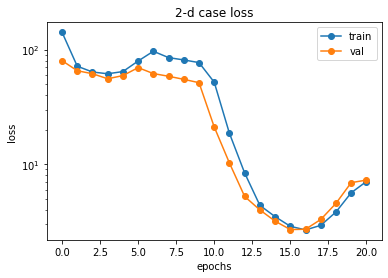

test_data original space:


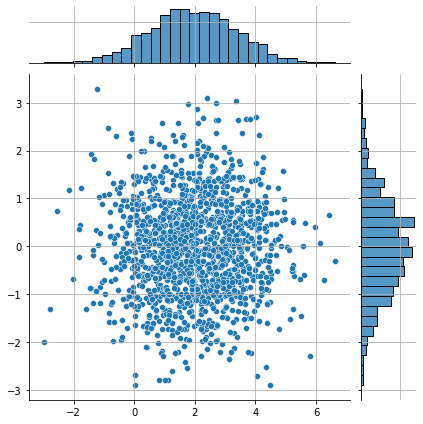

test data in encoded space


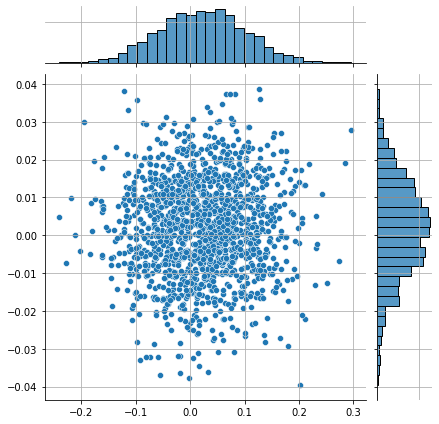

In [46]:
# # combine previous loss curves with the current ones
plot_loss_curves(train_loss=train_losses+train_losses_3+train_losses_2, 
                 val_loss=val_losses+val_losses_3+val_losses_2,
                title="2-d case loss", log_scale=True)

# once again test the model
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

# now we can try to plot the code space 
print("test_data original space:")
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

Training Progress:  17%|█▋        | 1/6 [00:19<01:39, 19.84s/it]

Epoch 1/6, Training Loss: 22.63236512538365, Validation Loss: 25.30168342590332, LR: 0.001


Training Progress:  33%|███▎      | 2/6 [00:35<01:08, 17.22s/it]

Epoch 2/6, Training Loss: 28.632155511038643, Validation Loss: 27.51707649230957, LR: 0.001


Training Progress:  50%|█████     | 3/6 [00:50<00:49, 16.49s/it]

Epoch 3/6, Training Loss: 23.235895478384837, Validation Loss: 20.226371947755204, LR: 0.001


Training Progress:  67%|██████▋   | 4/6 [01:06<00:32, 16.10s/it]

Epoch 4/6, Training Loss: 22.675960530962264, Validation Loss: 23.90850067138672, LR: 0.0001


Training Progress:  83%|████████▎ | 5/6 [01:22<00:15, 15.99s/it]

Epoch 5/6, Training Loss: 28.441042255946567, Validation Loss: 28.172332763671875, LR: 0.0001


Training Progress: 100%|██████████| 6/6 [01:37<00:00, 16.24s/it]

Epoch 6/6, Training Loss: 28.94595067705427, Validation Loss: 31.71140480041504, LR: 0.0001
Training complete


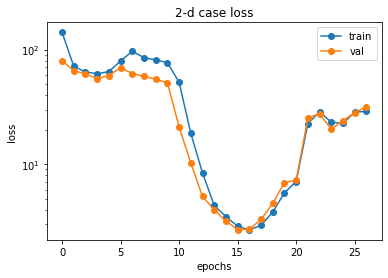

test_data original space:


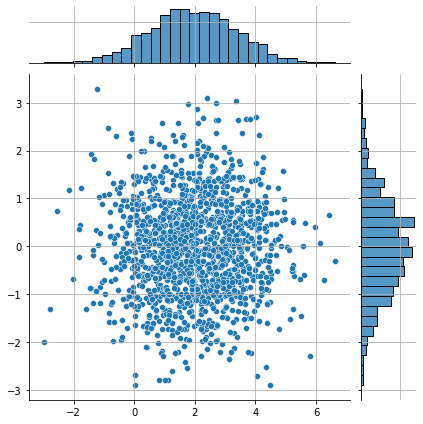

test data in encoded space


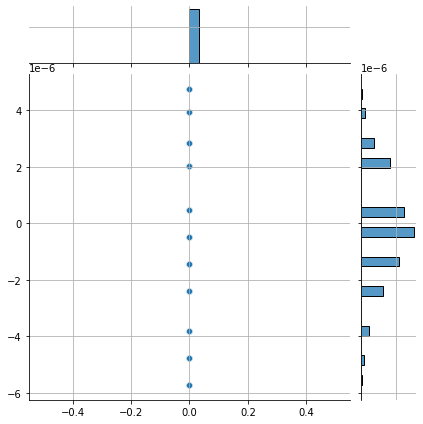

In [47]:
# # combine previous loss curves with the current ones
# train the model for a few more epochs
train_losses_4, val_losses_4, model_param_epoch_4 = train_and_evaluate(
    model=model_2d, train_loader=train_loader,val_loader=val_loader,
    lr=0.001, 
    num_epochs=6, 
    print_after=1, 
    scheduler_type='ReduceLROnPlateau',
    track_coefficients=False # let's not track coeffs, i need to fix it
) 

plot_loss_curves(train_loss=train_losses+train_losses_3+train_losses_2+train_losses_4, 
                 val_loss=val_losses+val_losses_3+val_losses_2+val_losses_4,
                title="2-d case loss", log_scale=True)

# once again test the model
test_tensor=torch.tensor(test_data, dtype=torch.float)
with torch.no_grad():
    encoded_test,_ = model_2d(test_tensor)

# now we can try to plot the code space 
print("test_data original space:")
plot_2d_scatter_with_marginals(test_data)

print("test data in encoded space")
plot_2d_scatter_with_marginals(encoded_test)

### Task for now: investigate the shape of x while working with the activation function. I think there is something definitely wrong here!

Let's investigate the activation function first

In [48]:
# spline_params = {
#     "mode": "fc",
#     "num_activations": 1,
#     "size": 5,
#     "range_": 10,
#     "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
#     "init": "relu",
#     "smin": 0.001,
#     "smax": 1 / 0.001,
#     "slope_constrained": True,
# }
# act_check_1=LinearSplineSlopeConstrained(**spline_params)


In [49]:
spline_params2 = {
    "mode": "fc",
    "num_activations": 2,
    "size": 5,
    "range_": 10,
    "grid_values": torch.tensor([-6.3, -4, 2.7, 4.5, 6.5]),
    "init": "relu",
    "smin": 0.001,
    "smax": 1 / 0.001,
    "slope_constrained": True,
}
act_check_2=LinearSplineSlopeConstrained(**spline_params2)

initial nodal_val_locs: tensor([[-6.3000, -4.0000,  2.7000,  4.5000,  6.5000],
        [-6.3000, -4.0000,  2.7000,  4.5000,  6.5000]])
initial fn values: Parameter containing:
tensor([0.0000, 0.0000, 2.7000, 4.5000, 6.5000, 0.0000, 0.0000, 2.7000, 4.5000,
        6.5000], requires_grad=True)


d:\Desktop\lipschitz_network_third_sem\Lipschitz_DSNN\activations\linearspline_slope_constraint.py:190: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.nodal_val_loc_tensor = torch.tensor(grid_values).expand((num_activations, size))


In [50]:
act_test_tensor2=torch.tensor([[1.,100.],[100.,1.],[100.,1.],[3.,100.]], 
                            dtype=torch.float32)
print(act_test_tensor2)

tensor([[  1., 100.],
        [100.,   1.],
        [100.,   1.],
        [  3., 100.]])


In [51]:
act_check_2(act_test_tensor2) # this did not throw error. why? # this makes sense!

tensor([[  2.0154, 100.0005],
        [100.0005,   2.0154],
        [100.0005,   2.0154],
        [  3.0005, 100.0005]], grad_fn=<ViewBackward0>)

In [52]:
act_check_2.grad_x_temp

tensor([[0.4030, 1.0000, 1.0000, 1.0000],
        [1.0000, 0.4030, 0.4030, 1.0000]], grad_fn=<LinearSpline_FuncBackward>)

In [53]:
act_test_tensor = torch.tensor([[3.],[100.]], dtype=torch.float32)
act_check_1(act_test_tensor)
act_check_1.grad_x_temp

NameError: name 'act_check_1' is not defined

In [85]:
# act_check_1(act_test_tensor)# throws error